<a href="https://colab.research.google.com/github/ramyamahesh1126/Deep-Learning/blob/Assignment3/DeepNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generate synthetic data using the equation you used and plot using 4d plot

x:(200, 3), weights:(3, 1),bias:(1,), y:(200, 1)


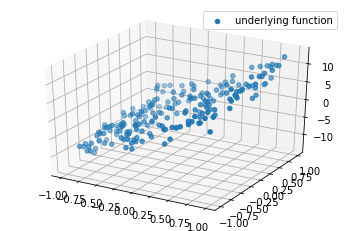

In [ ]:
import numpy as np

n=200
d=3
x= np.random.uniform(-1,1,(n,d))

weights_true = np.array([[5,1,2],]).T
bias_true = np.array([1])

y_true= (x ** 3) @ weights_true + x @weights_true + bias_true
print(f'x:{x.shape}, weights:{weights_true.shape},bias:{bias_true.shape}, y:{y_true.shape}')

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='our function')
  plt.legend()

plot_3d(x,y_true)

3 Layer Deep Neural Network in numpy

In [ ]:
!pip3 install python-mnist

In [ ]:
import numpy as np
import mnist

In [ ]:
class MLP(object):
    def __init__(self, eta=0.001, alpha=0.001, n_iter=50, batch_size=50):
        self.eta = eta
        self.alpha = alpha
        self.n_iter = n_iter
        self.batch_size = batch_size
        
        
    def one_hot_enc(self, y, num_labels=10):
        one_hot = np.zeros((num_labels, y.shape[0]), dtype=np.float32)
    
        for i, val in enumerate(y):
            one_hot[val,i] = 1.0
    
        return one_hot



    def add_bias_unit(self, layer, orientation):
        if orientation == 'row':
            updated_layer = np.ones((layer.shape[0]+1, layer.shape[1]))
            updated_layer[1:, :] = layer
        elif orientation == 'col':
            updated_layer = np.ones((layer.shape[0], layer.shape[1] + 1))
            updated_layer[:, 1:] = layer
    
        return updated_layer

    def init_weights(self, n_input, n_hidden_1, n_hidden_2, n_output, batch_size):
        w1 = np.random.randn(n_hidden_1, n_input+1)
        w2 = np.random.randn(n_hidden_2, n_hidden_1+1)
        w3 = np.random.randn(n_output, n_hidden_2+1)
        
        return w1, w2, w3

    def compute_forward_pass(self, input):
        a1 = self.add_bias_unit(input, orientation='col')
    
        z2 = np.matmul(self.w1, a1.transpose(1, 0))
        a2 = 1/(1 + np.exp(-z2))
        a2 = self.add_bias_unit(a2, orientation='row')
    
        z3 = np.matmul(self.w2, a2)
        a3 = 1/(1 + np.exp(-z3))
        a3 = self.add_bias_unit(a3, orientation='row')
    
        z4 = np.matmul(self.w3, a3)
        a4 = 1/(1 + np.exp(-z4))
    
        return a1, z2, a2, z3, a3, z4, a4

    def predict(self, a4):
        prediction = np.argmax(a4, axis=0)
        return prediction

    def compute_loss(self, prediction, label):
        term_1 = -1*label * np.log(prediction)
        term_2 = (1-label)*(np.log(1-prediction))
    
        loss = np.sum(term_1 - term_2)
        return loss

    def compute_backward_pass(self, outputs, label):
        a1, z2, a2, z3, a3, z4, a4 = outputs
    
        delta_4 = a4 - label
        sig_z3 = np.array(1/(1 + np.exp(-z3)))
        delta_3 = np.matmul(self.w3[:,1:].transpose(),delta_4)*sig_z3*(1-sig_z3)
               
        sig_z2 = np.array(1/(1 + np.exp(-z2)))
        delta_2 = np.matmul(self.w2[:,1:], delta_3)*(sig_z2)*(1-(sig_z2))
    
        grad_w1 = np.matmul(delta_2, a1)
        grad_w2 = np.matmul(delta_3, a2.transpose())
        grad_w3 = np.matmul(delta_4, a3.transpose())
    
        return grad_w1, grad_w2, grad_w3
            
    def norm(self, X, x_min, x_max):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom 
    
    def prep_data(self, X, y):
        
        X_ = []
        y_ = []
        
        itr = int(len(y)/self.batch_size)+1
        for j in range(1,itr):
            rng = j*self.batch_size
            X_.append(X[rng-self.batch_size:rng, :])
            y_.append(y[rng-self.batch_size:rng])
        
        X, y = np.array(X_), np.array(y_)
        X = self.norm(X, 0, 1)
        
        return X, y

    def fit(self, X, y):
        n_input = len(X[0,0,:]) #returns the flattened image size (28*28 = 784)
    
        n_hidden_1, n_hidden_2, n_output = 100, 100, 10
        self.w1, self.w2, self.w3 = self.init_weights(n_input, n_hidden_1, n_hidden_2,
                                    n_output, self.batch_size)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        delta_w3_prev = np.zeros(self.w3.shape)
        
        train_losses = []
        train_acc = []
    
    
        for i in range(self.n_iter):
            for j, (input, label) in enumerate(zip(X, y)):
                one_hot_label = self.one_hot_enc(label, num_labels=10)
                
                a1, z2, a2, z3, a3, z4, a4 = self.compute_forward_pass(input)
                loss = self.compute_loss(a4, one_hot_label)
                grad1, grad2, grad3 = self.compute_backward_pass([a1, z2, a2, z3, a3, z4, a4],
                                                one_hot_label)
    
                delta_w1, delta_w2, delta_w3 = self.eta*grad1, self.eta*grad2, self.eta*grad3
    
                self.w1 -= delta_w1 + delta_w1_prev*self.alpha
                self.w2 -= delta_w2 + delta_w2_prev*self.alpha
                self.w3 -= delta_w3 + delta_w3_prev*self.alpha
    
                delta_w1_prev, delta_w2_prev, delta_w3_prev = delta_w1, delta_w2, delta_w3
    
                train_losses.append(loss)
                predictions = self.predict(a4)
    
                wrong = np.where(predictions != label,
                                np.matrix([1.]), np.matrix([0.]))
    
                accuracy = 1 - np.sum(wrong)/self.batch_size
    
                train_acc.append(accuracy)
    
            print('epoch ', i, 'training accuracy %.2f' %
                    np.mean(np.matrix(train_acc)).item())
        

In [ ]:
import numpy as np
from urllib import request
import gzip
import pickle

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

if __name__ == '__main__':
    init()  

Download complete.
Save complete.


In [ ]:
#training the model
with open('/content/mnist.pkl', 'rb') as mnist:
     data = pickle.load(mnist)
mlp = MLP()

In [ ]:
X_train, y_train, X_test, y_test = data["training_images"], data["training_labels"], data["test_images"], data["test_labels"]
# print(data)
X_train, y_train = mlp.prep_data(X_train, y_train)
mlp.fit(X_train, y_train)

epoch  0 training accuracy 0.49
epoch  1 training accuracy 0.59
epoch  2 training accuracy 0.65
epoch  3 training accuracy 0.68
epoch  4 training accuracy 0.71
epoch  5 training accuracy 0.73
epoch  6 training accuracy 0.74
epoch  7 training accuracy 0.75
epoch  8 training accuracy 0.77
epoch  9 training accuracy 0.77
epoch  10 training accuracy 0.78
epoch  11 training accuracy 0.79
epoch  12 training accuracy 0.80
epoch  13 training accuracy 0.80
epoch  14 training accuracy 0.81
epoch  15 training accuracy 0.81
epoch  16 training accuracy 0.82
epoch  17 training accuracy 0.82
epoch  18 training accuracy 0.83
epoch  19 training accuracy 0.83
epoch  20 training accuracy 0.83
epoch  21 training accuracy 0.84
epoch  22 training accuracy 0.84
epoch  23 training accuracy 0.84
epoch  24 training accuracy 0.84
epoch  25 training accuracy 0.85
epoch  26 training accuracy 0.85
epoch  27 training accuracy 0.85
epoch  28 training accuracy 0.85
epoch  29 training accuracy 0.86
epoch  30 training a

3 layer deep neural network for non linear regression using pytorch

In [ ]:
import torch
import torch.nn as nn

In [ ]:
X = torch.tensor(([2, 9], [1, 5], [3, 6]), dtype=torch.float) # 3 X 2 tensor
y = torch.tensor(([92], [100], [89]), dtype=torch.float) # 3 X 1 tensor
xPredicted = torch.tensor(([4, 8]), dtype=torch.float) # 1 X 2 tensor

In [ ]:
print(X.size())
print(y.size())

torch.Size([3, 2])
torch.Size([3, 1])


In [ ]:
# scale units
X_max, _ = torch.max(X, 0)
xPredicted_max, _ = torch.max(xPredicted, 0)

X = torch.div(X, X_max)
xPredicted = torch.div(xPredicted, xPredicted_max)
y = y / 100  # max test score is 100
print(xPredicted)

tensor([0.5000, 1.0000])


In [ ]:
class Neural_Network(nn.Module):
    def __init__(self, ):
        super(Neural_Network, self).__init__()
        # parameters
        # TODO: parameters can be parameterized instead of declaring them here
        self.inputSize = 2
        self.outputSize = 1
        self.hiddenSize = 3
        
        # weights
        self.W1 = torch.randn(self.inputSize, self.hiddenSize) # 3 X 2 tensor
        self.W2 = torch.randn(self.hiddenSize, self.outputSize) # 3 X 1 tensor
        
    def forward(self, X):
        self.z = torch.matmul(X, self.W1) # 3 X 3 ".dot" does not broadcast in PyTorch
        self.z2 = self.sigmoid(self.z) # activation function
        self.z3 = torch.matmul(self.z2, self.W2)
        o = self.sigmoid(self.z3) # final activation function
        return o
        
    def sigmoid(self, s):
        return 1 / (1 + torch.exp(-s))
    
    def sigmoidPrime(self, s):
        # derivative of sigmoid
        return s * (1 - s)
    
    def backward(self, X, y, o):
        self.o_error = y - o # error in output
        self.o_delta = self.o_error * self.sigmoidPrime(o) # derivative of sig to error
        self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
        self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
        self.W1 += torch.matmul(torch.t(X), self.z2_delta)
        self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)
        
    def train(self, X, y):
        # forward + backward pass for training
        o = self.forward(X)
        self.backward(X, y, o)
        
    def saveWeights(self, model):
        # we will use the PyTorch internal storage functions
        torch.save(model, "NN")
        # you can reload model with all the weights and so forth with:
        # torch.load("NN")
        
    def predict(self):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(xPredicted))
        print ("Output: \n" + str(self.forward(xPredicted)))

In [ ]:
def __init__(self, ):
    super(Neural_Network, self).__init__()
    # parameters
    # TODO: parameters can be parameterized instead of declaring them here
    self.inputSize = 2
    self.outputSize = 1
    self.hiddenSize = 3

    # weights
    self.W1 = torch.randn(self.inputSize, self.hiddenSize) # 3 X 2 tensor
    self.W2 = torch.randn(self.hiddenSize, self.outputSize) # 3 X 1 tensor

In [ ]:
def forward(self, X):
    self.z = torch.matmul(X, self.W1) 
    self.z2 = self.sigmoid(self.z) # activation function
    self.z3 = torch.matmul(self.z2, self.W2)
    o = self.sigmoid(self.z3) # final activation function
    return o

In [ ]:
def backward(self, X, y, o):
    self.o_error = y - o # error in output
    self.o_delta = self.o_error * self.sigmoidPrime(o) 
    self.z2_error = torch.matmul(self.o_delta, torch.t(self.W2))
    self.z2_delta = self.z2_error * self.sigmoidPrime(self.z2)
    self.W1 += torch.matmul(torch.t(X), self.z2_delta)
    self.W2 += torch.matmul(torch.t(self.z2), self.o_delta)

In [ ]:
NN = Neural_Network()
for i in range(1000):  # trains the NN 1,000 times
    if (i % 100) == 0:
        print ("#" + str(i) + " Loss: " + str(torch.mean((y - NN(X))**2).detach().item()))  # mean sum squared loss
    NN.train(X, y)
NN.saveWeights(NN)
NN.predict()

print("Finished training!")

#0 Loss: 0.012904766015708447
#100 Loss: 0.003257172182202339
#200 Loss: 0.0031698625534772873
#300 Loss: 0.003125549294054508
#400 Loss: 0.003082589479163289
#500 Loss: 0.003038514405488968
#600 Loss: 0.002992813242599368
#700 Loss: 0.002945068059489131
#800 Loss: 0.0028947649989277124
#900 Loss: 0.0028413215186446905
Predicted data based on trained weights: 
Input (scaled): 
tensor([0.5000, 1.0000])
Output: 
tensor([0.9475])
Finished training!


Using Pytorch Lightening

In [ ]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-5c9681zl
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-5c9681zl
  Running command git submodule update --init --recursive -q
  From https://github.com/PyTorchLightning/lightning-tutorials
   * branch            290fb466de1fcc2ac6025f74b56906592911e856 -> FETCH_HEAD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 134 kB 33.6 MB/s 
     |████████████████████████████████| 397 kB 73.7 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 
     |████████████████████████████████| 1.1 MB 64.6 MB/s 
     |████████████████████████████████| 144 kB 59.8 MB/s 
     |████████████████████████████████| 94 kB 4.6 MB/s 
     |████████████████████████████████| 271 kB 69.1 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_ligh

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl

class LitAutoEncoder(pl.LightningModule):
	def __init__(self):
		super().__init__()
		self.encoder = nn.Sequential(
      nn.Linear(28 * 28, 64),
      nn.ReLU(),
      nn.Linear(64, 3))
		self.decoder = nn.Sequential(
      nn.Linear(3, 64),
      nn.ReLU(),
      nn.Linear(64, 28 * 28))

	def forward(self, x):
		embedding = self.encoder(x)
		return embedding

	def configure_optimizers(self):
		optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
		return optimizer

	def training_step(self, train_batch, batch_idx):
		x, y = train_batch
		x = x.view(x.size(0), -1)
		z = self.encoder(x)    
		x_hat = self.decoder(z)
		loss = F.mse_loss(x_hat, x)
		self.log('train_loss', loss)
		return loss

	def validation_step(self, val_batch, batch_idx):
		x, y = val_batch
		x = x.view(x.size(0), -1)
		z = self.encoder(x)
		x_hat = self.decoder(z)
		loss = F.mse_loss(x_hat, x)
		self.log('val_loss', loss)

# data
dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=1024)
val_loader = DataLoader(mnist_val, batch_size=1024)

# model
model = LitAutoEncoder()

# training
trainer = pl.Trainer(gpus=1)
trainer.fit(model, train_loader, val_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.4 K
1 | decoder | Sequential | 51.2 K
---------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

**Tensorflow**

Tensorflow variants

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

n = 325
d = 3

In [3]:
# x = Values used for generating the sample set
x = np.random.uniform(-1,1,(n,d)) 
weights_true = np.array([[5,9,4],]).T
bias_true = np.array([1])

In [8]:
# Sample Set or TRUE VALUE
y_true = (x**2) @ weights_true + x@weights_true + bias_true
print(f'Dimensions: {d} , x shape: {x.shape} , Weights shape: {weights_true.shape}, Bias Shape: {bias_true.shape} , Number of Samples: {n} , Sample Set Shape: {y_true.shape}')

Dimensions: 3 , x shape: (325, 3) , Weights shape: (3, 1), Bias Shape: (1,) , Number of Samples: 325 , Sample Set Shape: (325, 1)


/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


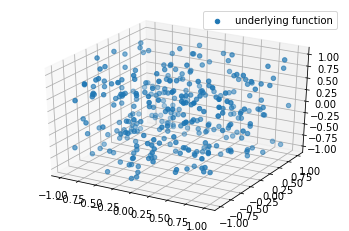

In [9]:
def plot_4d(x, y, y_pred=None):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0],x[:, 1],x[:, 2],y_true, label='underlying function')
  if y_pred is not None:
    ax.scatter(x[:, 0],x[:, 1],x[:, 2], y_pred, label='our function')
  plt.legend()

plot_4d(x, y_true)

Built-in Layers

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [11]:
inputs = keras.Input(shape=(3,))
l1 = layers.Dense(8, activation='relu', name='dense_1')(inputs)
outputs = layers.Dense(1, name='regression')(l1)


In [12]:
model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 32        
                                                                 
 regression (Dense)          (None, 1)                 9         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.fit(x, y_true, epochs=12)

Epoch 1/12
11/11 [==============================] - 2s 2ms/step - loss: 28.9714
Epoch 2/12
11/11 [==============================] - 0s 2ms/step - loss: 12.1707
Epoch 3/12
11/11 [==============================] - 0s 2ms/step - loss: 32.3664
Epoch 4/12
11/11 [==============================] - 0s 2ms/step - loss: 6.2446
Epoch 5/12
11/11 [==============================] - 0s 2ms/step - loss: 5.6780
Epoch 6/12
11/11 [==============================] - 0s 2ms/step - loss: 5.6073
Epoch 7/12
11/11 [==============================] - 0s 2ms/step - loss: 7.7259
Epoch 8/12
11/11 [==============================] - 0s 2ms/step - loss: 2.9180
Epoch 9/12
11/11 [==============================] - 0s 2ms/step - loss: 5.1349
Epoch 10/12
11/11 [==============================] - 0s 2ms/step - loss: 6.3361
Epoch 11/12
11/11 [==============================] - 0s 2ms/step - loss: 4.2415
Epoch 12/12
11/11 [==============================] - 0s 2ms/step - loss: 4.2194


/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir[0] == '-':


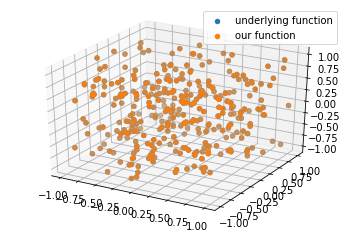

In [14]:
y_pred = model.predict(x)
plot_4d(x, y_true, y_pred)

Scratch

In [15]:
try:
    import tensorflow as tf
except:
    print("You don't have tensorflow installed yet")
try:
    import numpy as np
except:
    print("You don't have numpy installed yet")
try:
    import matplotlib.pyplot as plt
except:
    print("You don't have matplotlib installed yet")
from IPython.display import display, clear_output, Markdown
clear_output()

In [16]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
# Consider equation: 2(x1^2)+3(x2^2)+5(x3^2)+1
a = 5
b = 4
c = 9

### Function: $$y=(5)x^4+(4)x^3+(9)x^2$$

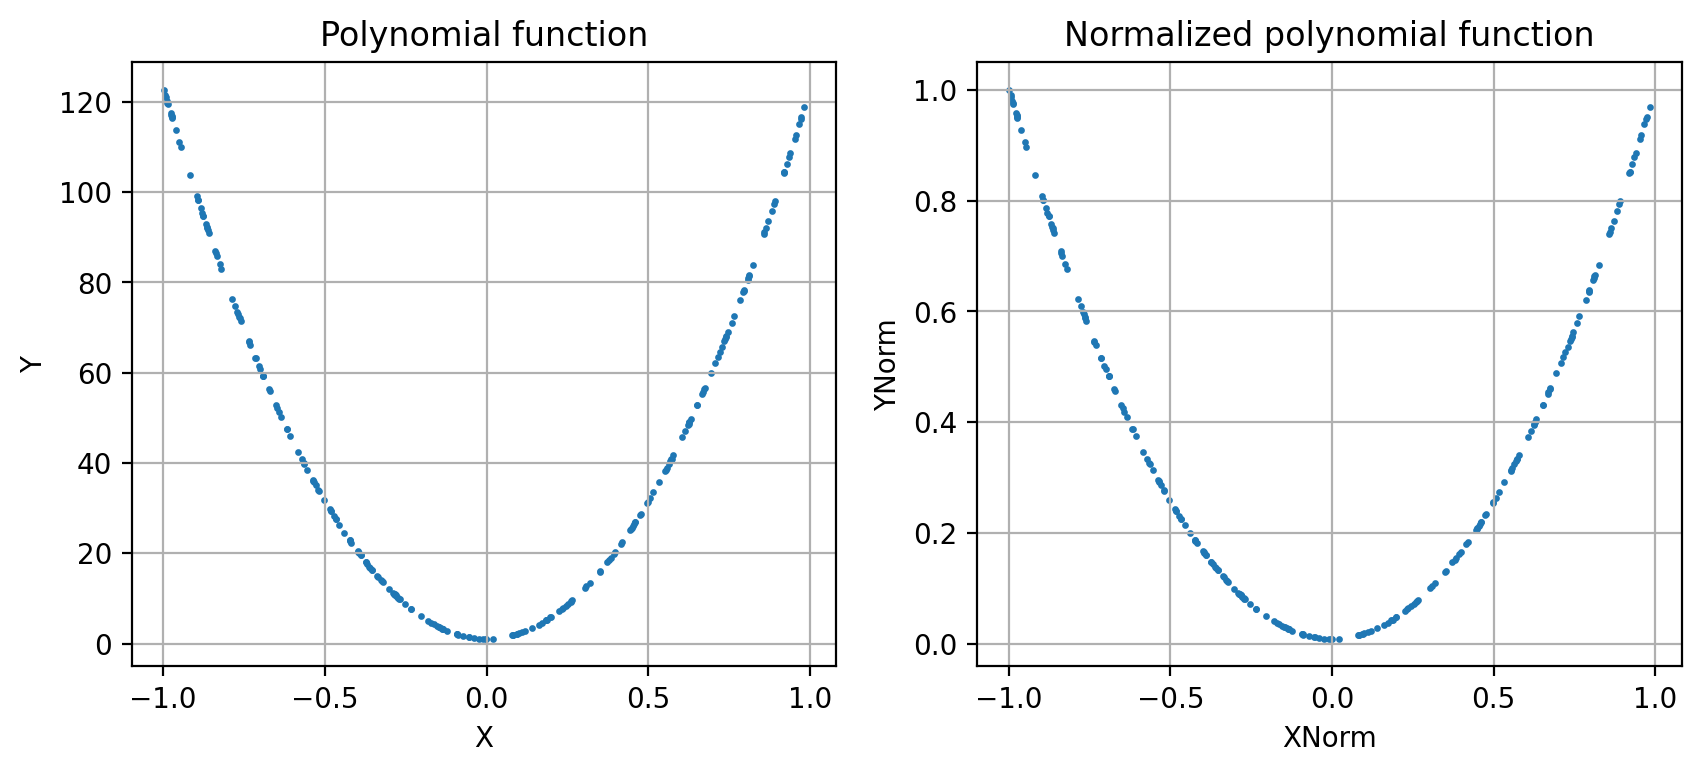

In [19]:
display(Markdown("### Function: $$y=("+str(a)+")x^4+("+str(b)+")x^3+("+str(c)+")x^2$$"))
x = (np.random.rand(1, 250) -0.5)*2
y_raw = (a*x)**2 + (b*x)**2 + (c*x)**2 + 1
y = y_raw/np.max(y_raw)
fig, ax = plt.subplots(ncols=2, figsize=[10,4], dpi=200)
ax[0].scatter(x, y_raw, s=2, label="Original Data")
ax[1].scatter(x, y, s=2, label="Normalized Data")
ax[0].set_xlabel("X")
ax[1].set_xlabel("XNorm")
ax[0].set_ylabel("Y")
ax[1].set_ylabel("YNorm")
ax[0].set_title("Polynomial function")
ax[1].set_title("Normalized polynomial function")
ax[0].grid()
ax[1].grid()
plt.show()


High Level API

In [20]:
batch_size = 2
epochs = 20
hidden_units = 12

In [21]:
# randomly splitting train/dev
indices = np.arange(0,x.shape[1])
np.random.shuffle(indices)
x_train = x[:,indices[:int(float(len(indices))*0.7)]]
x_test = x[:,indices[int(float(len(indices))*0.7):]]
y_train = y[:,indices[:int(float(len(indices))*0.7)]]
y_test = y[:,indices[int(float(len(indices))*0.7):]]
train_num_batches = int(float(x_train.shape[1])/batch_size)
test_num_batches = int(float(x_test.shape[1])/batch_size)
print("X Train shape: ", x_train.shape)
print("Y Train shape: ", y_train.shape)
print("X Test shape: ", x_test.shape)
print("Y Test shape: ", y_test.shape)

X Train shape:  (1, 175)
Y Train shape:  (1, 175)
X Test shape:  (1, 75)
Y Test shape:  (1, 75)


In [22]:
## Input Tensors: one for X values and one fot Y values: 

xx = tf.placeholder(tf.float32, shape=[1, batch_size], name='x')
yy = tf.placeholder(tf.float32, shape=[1, batch_size], name='y')

## HIDDEN LAYER:
# Initializing Weights (W) and biases (b) for the hidden layer:

W1 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[hidden_units,1]), name='W1')
b1 = tf.Variable(tf.zeros((hidden_units,1)), tf.float32, name='b1')

# Compute the matrices multiplication and apply RELU (Rectified Linear Unit) activation:

z1 = tf.add(tf.matmul(W1, xx), b1)
a1 = tf.nn.relu(z1)

## OUTPUT LAYER:
# Initializing Weights (W2) and biases (b2):

W2 = tf.Variable(tf.random_normal(dtype=tf.float32, shape=[1,hidden_units]), name='W2')
b2 = tf.Variable(tf.zeros((1,1)), tf.float32, name='b2')

# Compute matrices multiplication and apply TANH (hyperbolic tan) activation to the output layer:
z2 = tf.add(tf.matmul(W2, a1), b2)
y_hat = tf.tanh(z2)

# Compute loss function (difference between predicted Y (Y_HAT) and real Y):
cost = tf.reduce_mean(tf.square(yy - y_hat))

# Setting up Gradient Descend Optimizer to backpropagate the error and update weights and biases to minimize loss:

optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(cost, var_list=[W1,b1,W2,b2])

# This will initialize all variables and build the graph:
init = tf.global_variables_initializer()

Iteration number: 1740 of 1740

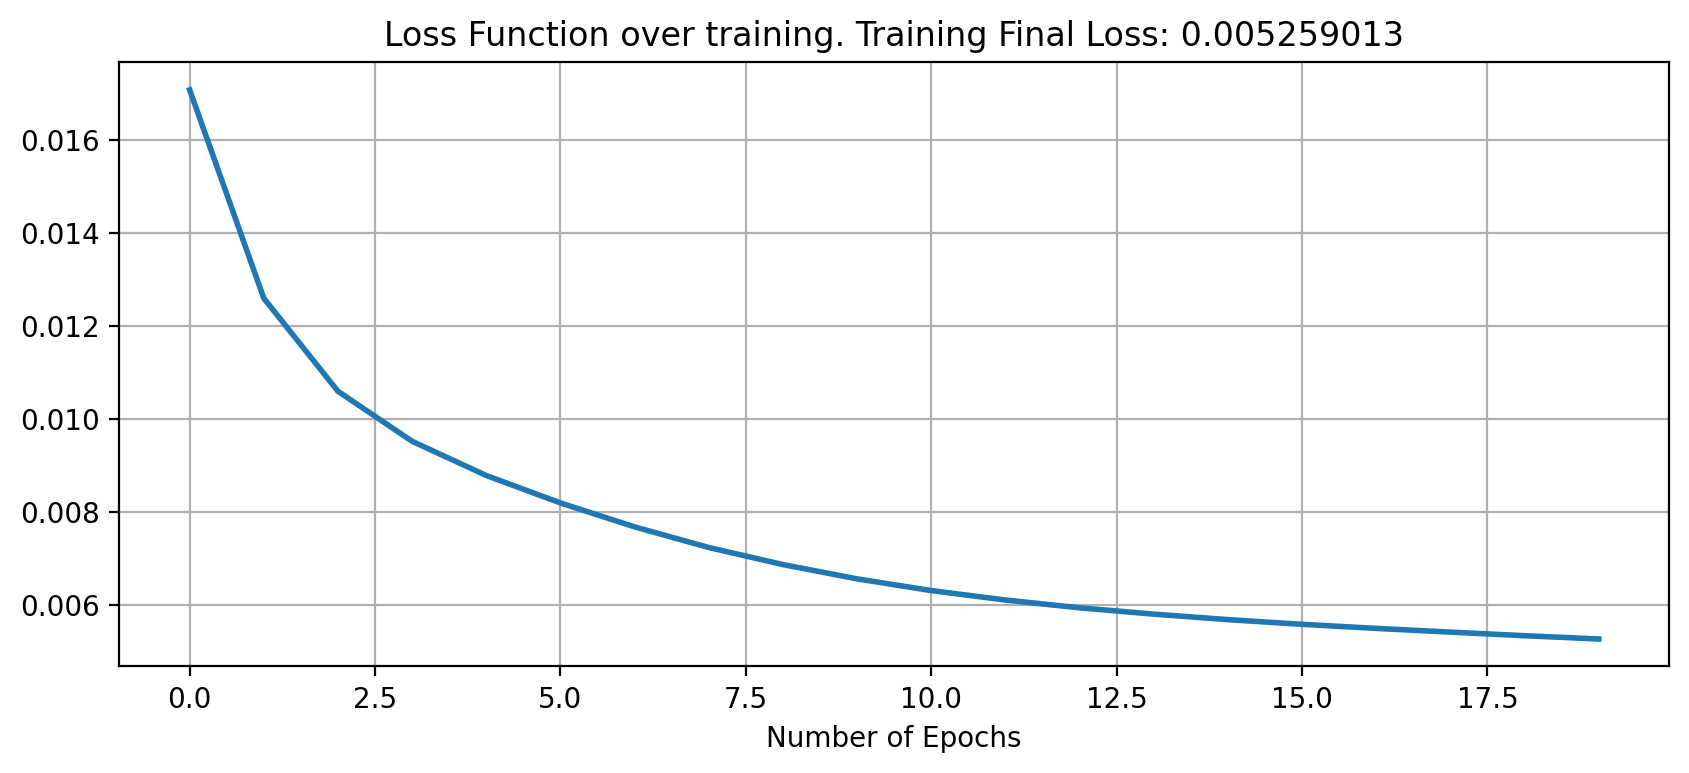

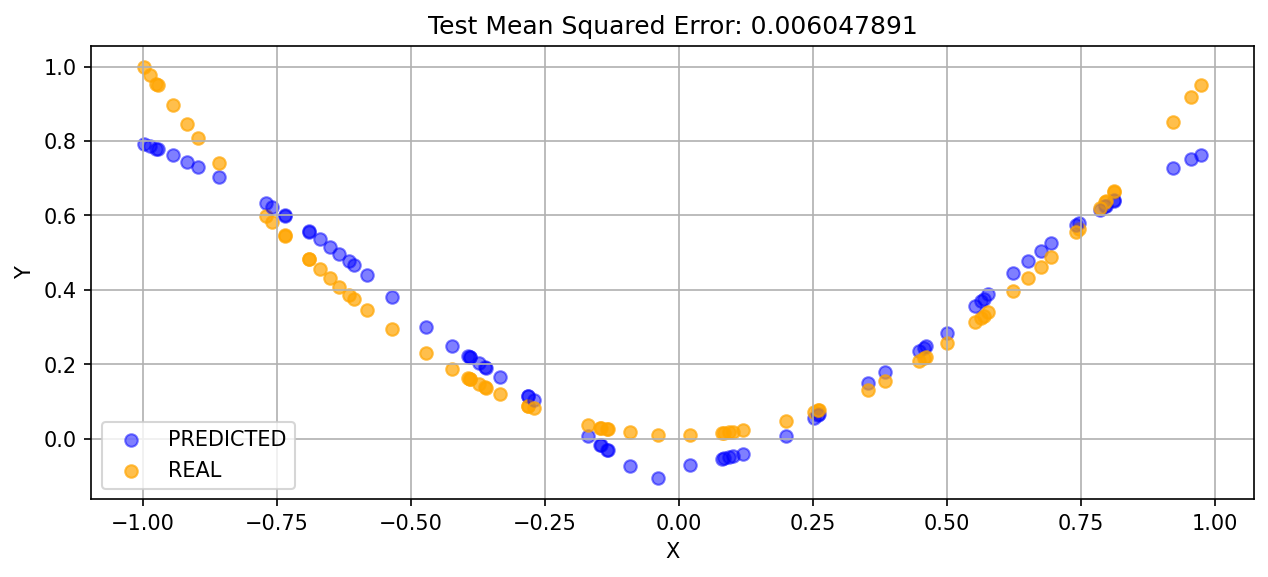

In [23]:
slider = 0
slider_max = train_num_batches*epochs
losses = []
with tf.Session() as sess:
    sess.run(init)
    for m in range(0,epochs):
        loss = []
        for k in range(0,train_num_batches):
            x_batch = x_train[:, k*batch_size:k*batch_size+batch_size]
            y_batch = y_train[:, k*batch_size:k*batch_size+batch_size]
            sess.run(train, feed_dict={xx: x_batch, yy: y_batch})
            loss_ = sess.run(cost, feed_dict={xx: x_batch, yy: y_batch})
            loss.append(loss_)
            slider += 1
            clear_output(wait=True)
            display(Markdown("Iteration number: "+str(slider)+" of "+str(slider_max)))
        losses.append(np.mean(loss))
            
    plt.figure(figsize=[10,4], dpi=200)
    plt.plot(losses, linewidth=2)
    plt.title("Loss Function over training. Training Final Loss: "+str(losses[-1]))
    plt.grid()
    plt.xlabel("Number of Epochs")
    plt.show()
    plt.figure(figsize=[10,4], dpi=150)
    losses_test = []
    for k in range(test_num_batches):
        x_batch = x_test[:, k*batch_size:k*batch_size+batch_size]
        y_batch = y_test[:, k*batch_size:k*batch_size+batch_size]
        plt.scatter(x_batch[0], sess.run(y_hat, feed_dict={xx: x_batch})[0], c='blue', alpha=.5)
        plt.scatter(x_batch[0], y_batch[0], c='orange', alpha=.7)
        losses_test.append(sess.run(cost, feed_dict={xx: x_batch, yy: y_batch}))
    loss_test = np.mean(losses_test)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Test Mean Squared Error: "+str(loss_test))
    plt.grid()
    plt.legend(["PREDICTED", "REAL"])
    plt.show()